Reloading modules sometimes causes errors. It's easier to just restart the notebook kernel and run from the start every time.

## Setup environment

In [1]:
checkpoint_dir="checkpoints"
if 'google.colab' in str(get_ipython()): #type: ignore
    COLAB = True
    print('Running on colab')
    %cd /content/
    !git clone https://github.com/TeamDman/Vehicular-Game-Theory
    %cd /content/Vehicular-Game-Theory/platoongame
    !git pull

    from utils import get_device
    import torch
    assert get_device() == torch.device("cuda")

    use_gdrive_checkpoints = True #@param {type:"boolean"}
    if use_gdrive_checkpoints:
        from google.colab import drive #type: ignore
        drive.mount('/content/drive')

        !mkdir -p /content/drive/MyDrive/checkpoints
        checkpoints_dir = "/content/drive/MyDrive/checkpoints"
else:
    COLAB = False
    print('Not running on colab')

Not running on colab


## Configuration

### Seed RNG

In [2]:
import random
random_seed = 42 #@param {type:"integer"}
random.seed(random_seed)
import torch
torch.manual_seed(random_seed)

### Vehicle provider config

In [3]:
from vehicles import JsonVehicleProvider, RandomVehicleProvider, RubbishVehicleProvider


provider = "random" #@param ["random", "json", "rubbish"]
if provider == "json":
  vehicle_provider = JsonVehicleProvider("../subgame/python/solutions.json")
elif provider == "random":
  vehicle_provider=RandomVehicleProvider(
    # this affects model shape
    num_max_vulns=7 #@param {type:"integer"}
    ,
    prob_mu=0.5 #@param {type:"number"}
    ,
    prob_sigma=0.25 #@param {type:"number"}
    ,
    sev_mu=2 #@param {type:"number"}
    ,
    sev_sigma=1 #@param {type:"number"}
    ,
  )
elif provider == "rubbish":
  vehicle_provider=RubbishVehicleProvider()
else:
  raise ValueError("unknown provider chosen")

In [4]:
from pprint import pprint
import dataclasses
pprint(dataclasses.asdict(vehicle_provider.next()))

{'in_platoon': False,
 'risk': 2.3366904258728027,
 'vulnerabilities': ({'prob': 0.5841726064682007,
                      'severity': 2,
                      'state': <CompromiseState.NOT_COMPROMISED: 1>},)}


### Game config

In [5]:
from game import GameConfig

game_config=GameConfig(
    max_vehicles=30 #@param {type:"integer"}
    ,
    cycle_every=5 #@param {type:"integer"}
    ,
    cycle_allow_platoon=False #@param {type:"boolean"}
    ,
    cycle_num=3 #@param {type:"integer"}
)

### Attacker agent config

In [6]:
from agents import AttackerAgent, PassiveAgent, BasicAttackerAgent
from game import State

attacker_ = "humanish" #@param ["passive", "humanish"]
if attacker_ == "passive":
  attacker = PassiveAgent()
elif attacker_ == "humanish":
  def get_attacker_utility(self:AttackerAgent, state: State) -> float:
    members = [vehicle for vehicle in state.vehicles if vehicle.in_platoon]
    comp = [1 for v in members for vuln in v.vulnerabilities]
    return len(comp)

  attacker = BasicAttackerAgent(
    attack_limit=1 #@param {type:"integer"}
    ,
    attack_interval=5 #@param {type:"integer"},
    ,
    utility_func=get_attacker_utility
  )
else:
  raise ValueError("unknown attacker chosen")

### Defender agent config

In [7]:
from agents import WolpertingerDefenderAgent
from models import StateShapeData
from vehicles import CompromiseState, Vehicle, Vulnerability

# def get_utility(self:WolpertingerDefenderAgent, state: State) -> float:
#     members = [vehicle for vehicle in state.vehicles if vehicle.in_platoon]
#     compromises = sum([vuln.severity ** 2 for vehicle in members for vuln in vehicle.vulnerabilities if vuln.state != CompromiseState.NOT_COMPROMISED])
#     return len(members) * 2.5 - compromises

def get_defender_utility(self:WolpertingerDefenderAgent, state: State) -> float:
    members = [vehicle for vehicle in state.vehicles if vehicle.in_platoon]
    comp = [1 for v in members for vuln in v.vulnerabilities if vuln.state != CompromiseState.NOT_COMPROMISED]
    if len(comp) > 0: return 0
    return len(members)

# def get_defender_utility(self:WolpertingerDefenderAgent, state: State) -> float:
#     return 100 - sum([
#         vuln.severity for vehicle in state.vehicles
#         if vehicle.in_platoon
#         for vuln in vehicle.vulnerabilities
#         if vuln.state != CompromiseState.NOT_COMPROMISED
#     ])
    # members = [vehicle for vehicle in state.vehicles if vehicle.in_platoon]
    # compromises = sum([vuln.severity ** 2 for vehicle in members for vuln in vehicle.vulnerabilities if vuln.state != CompromiseState.NOT_COMPROMISED])
    # return len(members) * 2.5 - compromises


# def get_utility(self:WolpertingerDefenderAgent, state: State) -> float:
#     return sum([
#         -10/(vuln.severity)
#         for vehicle in state.vehicles if not vehicle.in_platoon
#         for vuln in vehicle.vulnerabilities
#         if vuln.state == CompromiseState.NOT_COMPROMISED
#     ]) - sum([
#         vuln.severity
#         for vehicle in state.vehicles if vehicle.in_platoon
#         for vuln in vehicle.vulnerabilities
#         if vuln.state != CompromiseState.NOT_COMPROMISED
#     ])
    
load_checkpoint = False #@param {type:"boolean"}
defender=WolpertingerDefenderAgent(
    state_shape_data=StateShapeData(
        num_vehicles=game_config.max_vehicles,
        num_vehicle_features=Vehicle.get_shape()[0],
        num_vulns=vehicle_provider.max_vulns,
        num_vuln_features=Vulnerability.get_shape()[0]
    ),
    learning_rate=0.001 #@param {type:"number"}
    ,
    num_proposals=3 #@param {type: "integer"}
    ,
    utility_func=get_defender_utility
    ,
    ou_theta = 0.0 #@param {type: "number"}
    ,
    ou_mu = 0.0 #@param {type: "number"}
    ,
    ou_sigma = 3 #@param {type: "number"}
    ,
    epsilon_decay_time=50000 #@param {type: "integer"}
)

if load_checkpoint:
  defender.load(
    dir=checkpoints_dir,
    prefix="2022-10-13 2258-27 054659" #@param {type: "string"}
)

c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Baseline evaluation

untrained defender


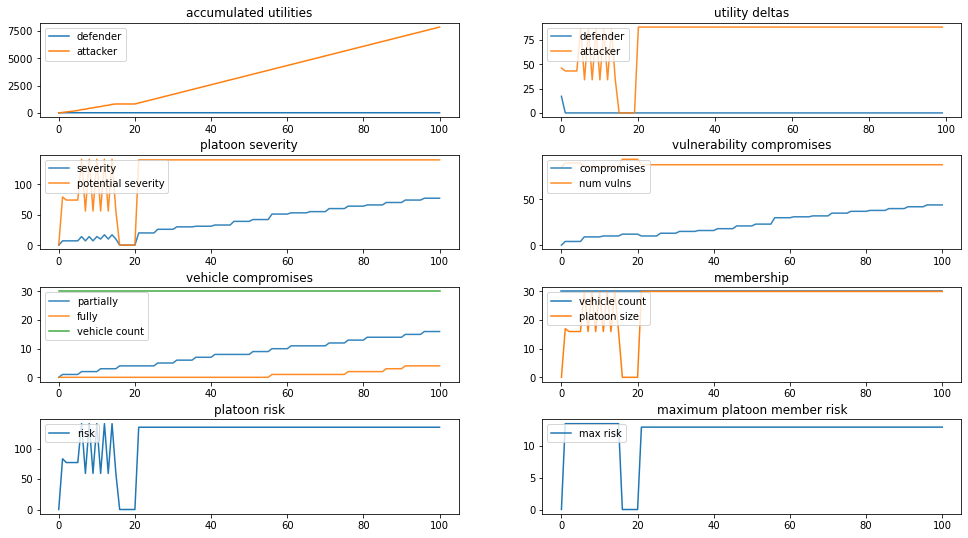

In [8]:
from agents import RandomDefenderAgent
from evaluation import get_episode_metrics

print("untrained defender")
get_episode_metrics(
    defender_agent=defender,
    attacker_agent=attacker,
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    num_turns=100 #@param {type:"integer"}
).plot()

random defender


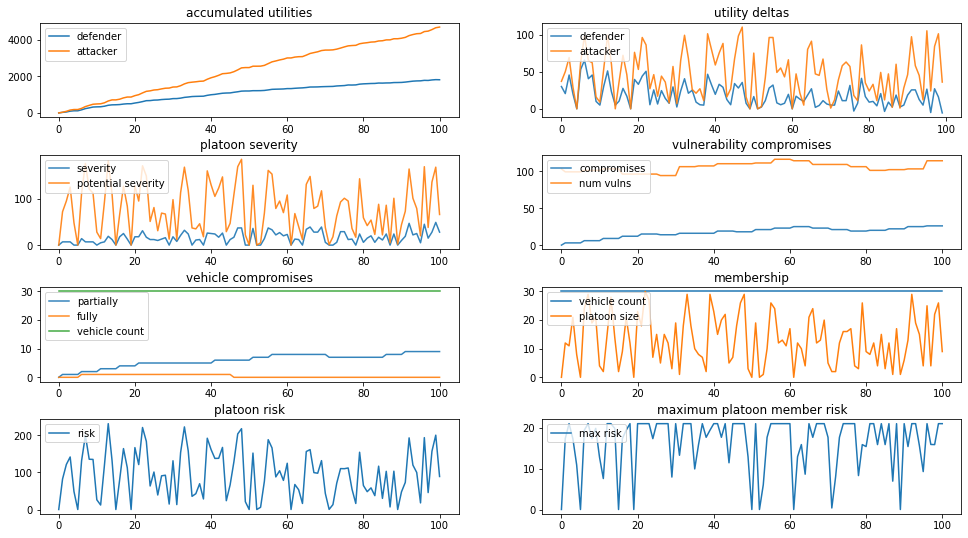

In [9]:
print("random defender")
get_episode_metrics(
    defender_agent=RandomDefenderAgent(),
    attacker_agent=attacker,
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    num_turns=100 #@param {type:"integer"}
).plot()

## Training

### Replay memory config

In [10]:
from memory import DequeReplayMemory

memory = DequeReplayMemory(
    capacity=10000 #@param {type:"integer"}
)

### Training metrics tracker config

In [11]:
from metrics import TrainingMetricsTracker
tracker = TrainingMetricsTracker()

### Trainer config

In [12]:
from training import WolpertingerDefenderAgentTrainer, WolpertingerDefenderAgentTrainerConfig
trainer = WolpertingerDefenderAgentTrainer(WolpertingerDefenderAgentTrainerConfig(
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    attacker_agent=attacker,
    defender_agent=defender,
    checkpoint_interval=-1 #@param {type:"integer"}
    ,
    memory=memory,
    metrics_tracker=tracker,
    batch_size=400 #@param {type:"integer"}
    ,
    train_steps=50 #@param {type:"integer"}
    ,
    train_interval=5 #@param {type:"integer"}
    ,
    warmup_replay=1000 #@param {type:"integer"}
    ,
    max_steps_per_episode=50 #@param {type:"integer"}
    ,
    update_policy_interval=10 #@param {type:"integer"}
    ,
    policy_update_type="soft" #@param ["soft", "hard"]
    ,
    reward_gamma = 0.99 #@param {type:"number"}
    ,
    soft_update_tau = 0.001 #@param {type:"number"}
    ,
    # epsilon_start = 0.9 #@param {type:"number"}
    # ,
    # epsilon_end = 0.05 #@param {type:"number"}
    # ,
    # epsilon_decay = 2500 #@param {type:"number"}
    # ,
))
# trainer.plot_epsilon_threshold(num_steps=20000)

### Perform training

In [13]:
trainer.train()

Warming up...


  0%|          | 0/1000 [00:00<?, ?it/s]

Warmup complete~!


  0%|          | 0/50 [00:00<?, ?it/s]

2022-10-19 2304-50 349873 episode 21 step 5 optimizing 

c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\torch\distributions\distribution.py:161: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


loss=15.7997 diff={max=22.8619, min=0.0142, mean=1.4414} policy_loss=-21.0513 policy updated! 
2022-10-19 2304-52 425870 episode 21 step 10 optimizing loss=421.9827 diff={max=28.7132, min=0.6868, mean=19.8800} policy_loss=-4.1497 
2022-10-19 2304-54 276870 episode 21 step 15 optimizing loss=21.7786 diff={max=19.3564, min=0.1660, mean=4.2192} policy_loss=0.1120 
2022-10-19 2304-56 078906 episode 21 step 20 optimizing loss=16.6627 diff={max=24.0113, min=0.0007, mean=1.3822} policy_loss=0.1525 
2022-10-19 2304-57 935907 episode 21 step 25 optimizing loss=18.3458 diff={max=23.0798, min=0.0038, mean=1.6002} policy_loss=0.1225 
2022-10-19 2304-59 734907 episode 21 step 30 optimizing loss=15.1639 diff={max=27.0567, min=0.0016, mean=1.3360} policy_loss=0.0930 
2022-10-19 2305-01 522921 episode 21 step 35 optimizing loss=16.7745 diff={max=23.9920, min=0.0001, mean=1.3676} policy_loss=0.0674 
2022-10-19 2305-03 418448 episode 21 step 40 optimizing loss=17.1774 diff={max=27.0024, min=0.0001, mean

### View training metrics

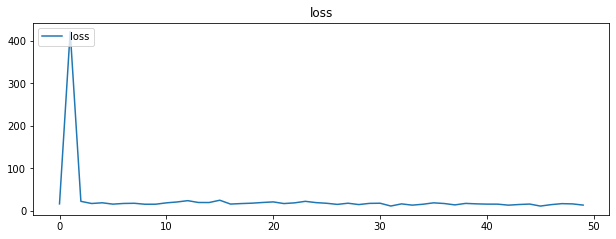

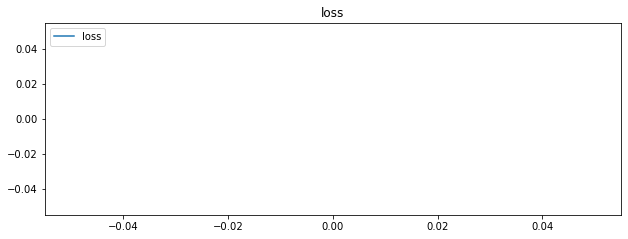

In [14]:
tracker.plot()
tracker.plot(only_show_small_loss=True)

## Evaluation

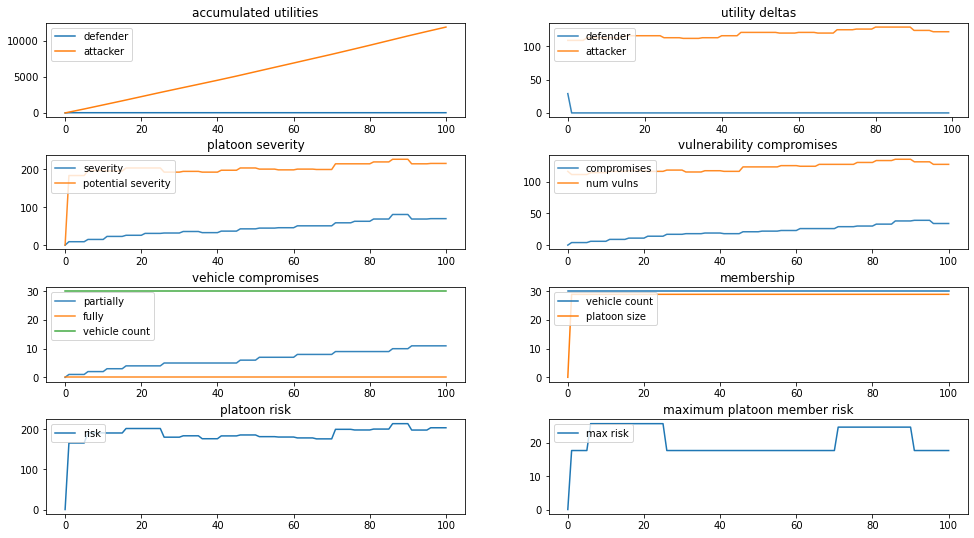

In [15]:
get_episode_metrics(
    defender_agent=defender,
    attacker_agent=attacker,
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    num_turns=100 #@param {type:"integer"}
).plot()

In [16]:
from evaluation import sample_model_outputs
sample_model_outputs(
    defender_agent=defender,
    memory=memory,
)

action.members tensor([[ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
          10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
          10., -10.,  10.,  10.,  10.,  10.]], grad_fn=<SumBackward1>)
q_pred tensor([1.5401, 1.1423, 1.1469, 1.3780, 1.2357, 1.4339, 1.5812, 1.3177, 1.2406,
        1.7701], grad_fn=<ReshapeAliasBackward0>)
batch.reward tensor([0., 0., 0., 0., 0., 2., 0., 0., 0., 0.])
pred reward err tensor([ 1.5401,  1.1423,  1.1469,  1.3780,  1.2357, -0.5661,  1.5812,  1.3177,
         1.2406,  1.7701], grad_fn=<SubBackward0>)


## Manually checkpoint model

In [17]:
from utils import get_prefix

manual_checkpoint = False #@param {type:"boolean"}
if manual_checkpoint:
    prefix = get_prefix()
    defender.save(dir=checkpoints_dir, prefix=prefix)
    trainer.config.dump(dir=checkpoints_dir, prefix=prefix)
    print(prefix)